In [2]:
# import dtale
import os
import pandas as pd
import numpy as np
from numpy import mean, std
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
print(os.getcwd())
dpath = os.path.join(os.getcwd(), "..\\Spaceship Titanic\\space_titanic_data")
print(dpath)

C:\ALEX\Kaggle\space_titanic
C:\ALEX\Kaggle\space_titanic\..\Spaceship Titanic\space_titanic_data


In [4]:
files1 = os.listdir(dpath)
files2 = [os.path.join(dpath, f) for f in files1]
files = [f for f in files2 if os.path.isfile(f)]
print(files)

['C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\space_titanic_data\\sample_submission.csv', 'C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\space_titanic_data\\test.csv', 'C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\space_titanic_data\\train.csv']


## Preprocess Functions

### Transfer all to ONE HOT ENCODER and Cabin break down to 3 types of data
### Missing cost values are set to 0

In [5]:
def get_train_data_transform_rev1():
    df_ = pd.read_csv(files[2])  # the training data
    dft_ = transform_data(df_)
    df_id = dft_.loc[:, dft_.columns == 'PassengerId']
    dfd_ = dft_.loc[:, dft_.columns != 'PassengerId']  # passanger id should not be input for training
    X = dfd_.loc[:, dfd_.columns != 'Transported']
    Y = dfd_[['Transported']]    
    return X, Y, df_id

def get_train_data_transform_rev2():
    df_ = pd.read_csv(files[2])  # the training data
    dft_ = transform_data_rev2(df_)
    df_id = dft_.loc[:, dft_.columns == 'PassengerId']
    dfd_ = dft_.loc[:, dft_.columns != 'PassengerId']  # passanger id should not be input for training
    X = dfd_.loc[:, dfd_.columns != 'Transported']
    Y = dfd_[['Transported']]    
    return X, Y, df_id

def get_test_data_transform_rev1():
    df_ = pd.read_csv(files[1])  # the test data
    dft_ = transform_data(df_)
    df_id = dft_.loc[:, dft_.columns == 'PassengerId']
    X = dft_.loc[:, dft_.columns != 'PassengerId']  # passanger id should not be input for training
    return X, df_id

def get_test_data_transform_rev2():
    df_ = pd.read_csv(files[1])  # the test data
    dft_ = transform_data_rev2(df_)
    df_id = dft_.loc[:, dft_.columns == 'PassengerId']
    X = dft_.loc[:, dft_.columns != 'PassengerId']  # passanger id should not be input for training
    return X, df_id

In [6]:
def transform_data(df_):
    df = df_.copy()
    
    df['Home_Earth'] = df.apply(lambda row: 1 if row['HomePlanet'] == 'Earth' else 0, axis=1)
    df['Home_Europa'] = df.apply(lambda row: 1 if row['HomePlanet'] == 'Europa' else 0, axis=1)
    df['Home_Mars'] = df.apply(lambda row: 1 if row['HomePlanet'] == 'Mars' else 0, axis=1)
    df['cryo_sleep_true'] = df.apply(lambda row: 1 if row['CryoSleep'] == True else 0, axis=1)
    df['cryo_sleep_false'] = df.apply(lambda row: 1 if row['CryoSleep'] == False else 0, axis=1)    
    df['destination_cancri'] = df.apply(lambda row: 1 if row['Destination'] == '55 Cancri e' else 0, axis=1)
    df['destination_pso'] = df.apply(lambda row: 1 if row['Destination'] == 'PSO J318.5-22' else 0, axis=1)
    df['destination_trappist'] = df.apply(lambda row: 1 if row['Destination'] == 'TRAPPIST-1e' else 0, axis=1)    
    df['vip_true'] = df.apply(lambda row: 1 if row['VIP'] == True else 0, axis=1)
    df['vip_false'] = df.apply(lambda row: 1 if row['VIP'] == False else 0, axis=1)    
    
    ccc = df['Cabin'].str.split("/").values
    c = [k[0] for k in ccc if type(k) == list]
    cc = list(set(c))
    cc.sort()
    cc_d = {cc[i]:(i+1) for i in range(len(cc))}
    s = [k[2] for k in ccc if type(k) == list]
    ss = list(set(s))
    ss.sort()
    ss_d = {ss[i]:(i+1) for i in range(len(ss))}
    df['cabin_row_'] = df.apply(lambda row: cc_d[row['Cabin'].split("/")[0]] if type(row['Cabin']) == str else 0, axis=1)
    m = max(df['cabin_row_'].values)
    df['cabin_row'] = df['cabin_row_'] / m
    df['cabin_t'] = df.apply(lambda row: 1 if type(row['Cabin']) == str and row['Cabin'].split("/")[0] == 'T' else 0, axis=1)
    df['cabin_num_'] = df.apply(lambda row: int(row['Cabin'].split("/")[1]) if type(row['Cabin']) == str else 0, axis=1)
    m = max(df['cabin_num_'].values)
    df['cabin_num'] = df['cabin_num_'] / m
    df['cabin_side_'] = df.apply(lambda row: ss_d[row['Cabin'].split("/")[2]] if type(row['Cabin']) == str else 0, axis=1)    
    m = max(df['cabin_side_'].values)
    df['cabin_side'] = df['cabin_side_'] / m
    df = df.drop(['cabin_row_', 'cabin_num_', 'cabin_side_'], axis=1)
    
    max_age = max(df['Age'].values)
    df['age_norm'] = df.apply(lambda row: row['Age']/max_age if not pd.isnull(row['Age']) else 0, axis=1)    
    dfc = df.drop(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP'], axis=1)
    
    dfc['RoomService'].fillna(0, inplace=True)
    dfc['roomservice'] = dfc['RoomService'] / max(dfc['RoomService'].values)
    dfc['FoodCourt'].fillna(0, inplace=True)
    dfc['foodcourt'] = dfc['FoodCourt'] / max(dfc['FoodCourt'].values)
    dfc['ShoppingMall'].fillna(0, inplace=True)
    dfc['shoppingmall'] = dfc['ShoppingMall'] / max(dfc['ShoppingMall'].values)
    dfc['Spa'].fillna(0, inplace=True)
    dfc['spa'] = dfc['Spa'] / max(dfc['Spa'].values)
    dfc['VRDeck'].fillna(0, inplace=True)
    dfc['vrdeck'] = dfc['VRDeck'] / max(dfc['VRDeck'].values)
    dfc = dfc.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name'], axis=1)
    
    return dfc

### Same as above but missing costs are imputed using KNN instead of set to 0

In [7]:
def transform_data_rev2(df_):
    df = df_.copy()
    
    df['Home_Earth'] = df.apply(lambda row: 1 if row['HomePlanet'] == 'Earth' else 0, axis=1)
    df['Home_Europa'] = df.apply(lambda row: 1 if row['HomePlanet'] == 'Europa' else 0, axis=1)
    df['Home_Mars'] = df.apply(lambda row: 1 if row['HomePlanet'] == 'Mars' else 0, axis=1)
    df['cryo_sleep_true'] = df.apply(lambda row: 1 if row['CryoSleep'] == True else 0, axis=1)
    df['cryo_sleep_false'] = df.apply(lambda row: 1 if row['CryoSleep'] == False else 0, axis=1)    
    df['destination_cancri'] = df.apply(lambda row: 1 if row['Destination'] == '55 Cancri e' else 0, axis=1)
    df['destination_pso'] = df.apply(lambda row: 1 if row['Destination'] == 'PSO J318.5-22' else 0, axis=1)
    df['destination_trappist'] = df.apply(lambda row: 1 if row['Destination'] == 'TRAPPIST-1e' else 0, axis=1)    
    df['vip_true'] = df.apply(lambda row: 1 if row['VIP'] == True else 0, axis=1)
    df['vip_false'] = df.apply(lambda row: 1 if row['VIP'] == False else 0, axis=1)    
    
    ccc = df['Cabin'].str.split("/").values
    c = [k[0] for k in ccc if type(k) == list]
    cc = list(set(c))
    cc.sort()
    cc_d = {cc[i]:(i+1) for i in range(len(cc))}
    s = [k[2] for k in ccc if type(k) == list]
    ss = list(set(s))
    ss.sort()
    ss_d = {ss[i]:(i+1) for i in range(len(ss))}
    df['cabin_row_'] = df.apply(lambda row: cc_d[row['Cabin'].split("/")[0]] if type(row['Cabin']) == str else 0, axis=1)
    m = max(df['cabin_row_'].values)
    df['cabin_row'] = df['cabin_row_'] / m
    df['cabin_t'] = df.apply(lambda row: 1 if type(row['Cabin']) == str and row['Cabin'].split("/")[0] == 'T' else 0, axis=1)
    df['cabin_num_'] = df.apply(lambda row: int(row['Cabin'].split("/")[1]) if type(row['Cabin']) == str else 0, axis=1)
    m = max(df['cabin_num_'].values)
    df['cabin_num'] = df['cabin_num_'] / m
    df['cabin_side_'] = df.apply(lambda row: ss_d[row['Cabin'].split("/")[2]] if type(row['Cabin']) == str else 0, axis=1)    
    m = max(df['cabin_side_'].values)
    df['cabin_side'] = df['cabin_side_'] / m
    df = df.drop(['cabin_row_', 'cabin_num_', 'cabin_side_'], axis=1)
    
    max_age = max(df['Age'].values)
    df['age_norm'] = df.apply(lambda row: row['Age']/max_age if not pd.isnull(row['Age']) else 0, axis=1)    
    dfc = df.drop(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP'], axis=1)
    
    X = dfc.loc[:, (dfc.columns != 'Transported') & (dfc.columns != 'PassengerId') & (dfc.columns != 'Name')]
    xcols = list(X.columns)
    if 'Transported' in list(dfc.columns):
        Y = dfc[['Transported', 'PassengerId', 'Name']]
    else:
        Y = dfc[['PassengerId', 'Name']]
        
    imputer = KNNImputer()
    imputer.fit(X)
    Xtrans = imputer.transform(X)
    xtrans_df = pd.DataFrame(data=Xtrans, columns=xcols)
    dfc = pd.concat([xtrans_df, Y], axis=1)
    dfc['RoomService'].fillna(0, inplace=True)
    dfc['roomservice'] = dfc['RoomService'] / max(dfc['RoomService'].values)
    dfc['FoodCourt'].fillna(0, inplace=True)
    dfc['foodcourt'] = dfc['FoodCourt'] / max(dfc['FoodCourt'].values)
    dfc['ShoppingMall'].fillna(0, inplace=True)
    dfc['shoppingmall'] = dfc['ShoppingMall'] / max(dfc['ShoppingMall'].values)
    dfc['Spa'].fillna(0, inplace=True)
    dfc['spa'] = dfc['Spa'] / max(dfc['Spa'].values)
    dfc['VRDeck'].fillna(0, inplace=True)
    dfc['vrdeck'] = dfc['VRDeck'] / max(dfc['VRDeck'].values)
    dfc = dfc.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name'], axis=1)
    
    return dfc

# The Models - exploring models

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
test_size = 0.25

### The Data columns split

In [ ]:
X, Y, df_id = get_train_data_transform_rev1()

## Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
model = XGBClassifier(n_estimators=65, num_parallel_tree=40)  # , num_parallel_tree=10)  #, n_jobs=100)

In [11]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
model.fit(X_train, y_train)

## Model Predictions

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))    

## Version 2

In [ ]:
X2, Y2, df_id = get_train_data_transform_rev2()

In [ ]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=test_size)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))    

## Train-Validate with PCA

In [ ]:
pca = PCA(n_components =0.9)
Xt = pca.fit_transform(X)

In [ ]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=test_size)
    pca = PCA()
    Xt = pca.fit_transform(X_train)
    model.fit(Xt, y_train)
    Xt_test = pca.transform(X_test)
    y_pred = model.predict(Xt_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))    

## Rev3

In [ ]:
iso = IsolationForest(contamination=0.1)

In [ ]:
dfc2 = transform_data_rev2(df)
dfd2 = dfc2.loc[:, dfc2.columns != 'PassengerId']  # passanger id should not be input for training
X2 = dfd2.loc[:, dfd2.columns != 'Transported']
Y2 = dfd2[['Transported']]

In [ ]:
len(X2)

In [ ]:
for i in range(10):
    X_train_, X_test, y_train_, y_test = train_test_split(X2, Y2, test_size=test_size)
    
    yhat = iso.fit_predict(X_train_)
    mask = yhat != -1
    X_train, y_train = X_train_.loc[mask, :], y_train_.loc[mask, :]
#     print(f"pre rows: {y_train_.shape} ;  post rows: {len(X_train)}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))    

#### Full Train

In [ ]:
yhat = iso.fit_predict(X2)
mask = yhat != -1
X2_train, y2_train = X2.loc[mask, :], Y2.loc[mask, :]
model.fit(X2_train, y2_train)

In [ ]:
X1, Y1, df_idt = get_train_data_transform_rev1()
X2, Y2, df_idt = get_train_data_transform_rev2()
X1_t, df_id = get_test_data_transform_rev1()
X2_t, df_id = get_test_data_transform_rev2()

In [ ]:
model1 = XGBClassifier(n_estimators=65, num_parallel_tree=40)  # , num_parallel_tree=10)  #, n_jobs=100)
model2 = XGBClassifier(n_estimators=65, num_parallel_tree=40)  # , num_parallel_tree=10)  #, n_jobs=100)

In [ ]:
model1.fit(X1, Y1)
model2.fit(X2, Y2)

In [ ]:
y1_pred1 = model1.predict(X1_t)
y1_pred2 = model1.predict(X2_t)
y2_pred1 = model2.predict(X1_t)
y2_pred2 = model2.predict(X2_t)

In [ ]:
pred1_df1 = pd.DataFrame(data=y1_pred1, columns=['Transported'])
pred1_df1['Transported'] = pred1_df1['Transported'].astype(bool)

pred1_df2 = pd.DataFrame(data=y1_pred2, columns=['Transported'])
pred1_df2['Transported'] = pred1_df2['Transported'].astype(bool)

pred2_df1 = pd.DataFrame(data=y2_pred1, columns=['Transported'])
pred2_df1['Transported'] = pred2_df1['Transported'].astype(bool)

pred2_df2 = pd.DataFrame(data=y2_pred2, columns=['Transported'])
pred2_df2['Transported'] = pred2_df2['Transported'].astype(bool)

In [ ]:
df1_test1 = pd.concat([df_id, pred1_df1], axis=1)
df1_test2 = pd.concat([df_id, pred1_df2], axis=1)
df2_test1 = pd.concat([df_id, pred2_df1], axis=1)
df2_test2 = pd.concat([df_id, pred2_df2], axis=1)

In [ ]:
df1_test1.to_csv(f"xgboost11.csv", index=False)
df1_test2.to_csv(f"xgboost12.csv", index=False)
df2_test1.to_csv(f"xgboost21.csv", index=False)
df2_test2.to_csv(f"xgboost22.csv", index=False)

#  Models Predict
## Ensemble

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
bagging_kn = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bagging_kn = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=0.5)
bagging_ab = BaggingClassifier(AdaBoostClassifier(), max_samples=0.5, max_features=0.5)
bagging_gb = BaggingClassifier(GradientBoostingClassifier(), max_samples=0.5, max_features=0.5)
bagging_rf = BaggingClassifier(RandomForestClassifier(), max_samples=0.5, max_features=0.5)

In [ ]:
estimators1 = [('K-Neighbors', bagging_kn), ('Decision-Trees', bagging_kn), ('AdaBoost', bagging_ab), 
               ('Grad-Boost', bagging_gb), ('Random-Forest', bagging_rf)]
estimators2 = [('K-Neighbors', bagging_kn), ('Decision-Trees', bagging_kn), ('AdaBoost', bagging_ab), 
               ('Grad-Boost', bagging_gb), ('Random-Forest', bagging_rf)]

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X1, Y1, df_id = get_train_data_transform_rev1()
X2, Y2, df_id = get_train_data_transform_rev2()

In [ ]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=test_size)
#     yhat = iso.fit_predict(X_train_)
#     mask = yhat != -1
#     X_train, y_train = X_train_.loc[mask, :], y_train_.loc[mask, :]
    nn = []
    for (name, estimator) in estimators1:
        estimator.fit(X_train.values, y_train.values)
        y_pred = estimator.predict(X_test.values)
        accuracy = accuracy_score(y_test.values.reshape(len(y_test.values),), y_pred.reshape(len(y_pred),))
        nn.append([name, round(accuracy * 100.0, 2)])
    ss = [n[0]+": " + str(n[1]) + "%" for n in nn]
    s = "; ".join(ss)
    print(s)

In [ ]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=test_size)
    
#     yhat = iso.fit_predict(X_train_)
#     mask = yhat != -1
#     X_train, y_train = X_train_.loc[mask, :], y_train_.loc[mask, :]
    nn = []
    for (name, estimator) in estimators2:
        estimator.fit(X_train.values, y_train.values)
        y_pred = estimator.predict(X_test.values)
        accuracy = accuracy_score(y_test.values.reshape(len(y_test.values),), y_pred.reshape(len(y_pred),))
        nn.append([name, round(accuracy * 100.0, 2)])
    ss = [n[0]+": " + str(n[1]) + "%" for n in nn]
    s = "; ".join(ss)
    print(s)

In [ ]:
X1_test, df_id = get_test_data_transform_rev1()
X2_test, df_id = get_test_data_transform_rev2()

In [ ]:
dft = pd.read_csv(files[1])  # the test data
dfct = transform_data(dft)
pass_id = dfct[['PassengerId']]
dfdt = dfct.loc[:, dfct.columns != 'PassengerId']  # passanger id should not be input for training
X_test = dfdt
print(len(X_test))

In [ ]:
for (name, estimator) in estimators1:
    print(f"Start fitting {name}.")
    estimator.fit(X1.values, Y1.values)
    print(f"Done fitting {name}, now starting prediction of test.")
    
    y_pred = estimator.predict(X1_test.values)
    print(f"Done test prediction of {name}, now processing.")
    predictions = y_pred  # [round(value[0]) for value in y_pred]
    pred_df = pd.DataFrame(data=predictions, columns=['Transported'])
    pred_df['Transported'] = pred_df['Transported'].astype(bool)
    df_test = pd.concat([df_id, pred_df], axis=1)
    df_test.to_csv(f"submit_test revb1_test1 {name}.csv", index=False)

    y_pred = estimator.predict(X2_test.values)
    print(f"Done test prediction of {name}, now processing.")
    predictions = y_pred  # [round(value[0]) for value in y_pred]
    pred_df = pd.DataFrame(data=predictions, columns=['Transported'])
    pred_df['Transported'] = pred_df['Transported'].astype(bool)
    df_test = pd.concat([df_id, pred_df], axis=1)
    df_test.to_csv(f"submit_test revb1_test2 {name}.csv", index=False)    

In [ ]:
for (name, estimator) in estimators2:
    print(f"Start fitting {name}.")
    estimator.fit(X2.values, Y2.values)
    print(f"Done fitting {name}, now starting prediction of test.")
    
    y_pred = estimator.predict(X1_test.values)
    print(f"Done test prediction of {name}, now processing.")
    predictions = y_pred  # [round(value[0]) for value in y_pred]
    pred_df = pd.DataFrame(data=predictions, columns=['Transported'])
    pred_df['Transported'] = pred_df['Transported'].astype(bool)
    df_test = pd.concat([df_id, pred_df], axis=1)
    df_test.to_csv(f"submit_test revb2_test1 {name}.csv", index=False)

    y_pred = estimator.predict(X2_test.values)
    print(f"Done test prediction of {name}, now processing.")
    predictions = y_pred  # [round(value[0]) for value in y_pred]
    pred_df = pd.DataFrame(data=predictions, columns=['Transported'])
    pred_df['Transported'] = pred_df['Transported'].astype(bool)
    df_test = pd.concat([df_id, pred_df], axis=1)
    df_test.to_csv(f"submit_test revb2_test2 {name}.csv", index=False)    

In [ ]:
# dft = pd.read_csv(files[1])  # the test data
# dfct = transform_data(dft)
# dfdt = dfct.loc[:, dfct.columns != 'PassengerId']  # passanger id should not be input for training
# X2 = dfdt
# print(len(X2))

# y_pred = model2.predict(X2)
# predictions = [round(value[0]) for value in y_pred]
# len(predictions)

# pass_id = dfct[['PassengerId']]
# pred_df = pd.DataFrame(data=predictions, columns=['Transported'])
# pred_df['Transported'] = pred_df['Transported'].astype(bool)
# df_test = pd.concat([pass_id, pred_df], axis=1)

# df_test.to_csv('submit_test rev6 nn full train.csv', index=False)

## NN Model

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.constraints import MaxNorm

In [13]:
# x_in = Input(shape=(20,))
# x1 = Dense(64)(x_in)
# x2 = Dense(32)(x1)
# x3 = Dense(16)(x2)
# x_out = Dense(1)(x3)
# model = Model(inputs=x_in, outputs=x_out)

nn_model = tf.keras.Sequential()
nn_model.add(Dropout(0.2, input_shape=(20,)))
nn_model.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)))
nn_model.add(Dense(16, activation='relu', kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)))
nn_model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
nn_model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
nn_model3 = tf.keras.Sequential()
nn_model3.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(20,), kernel_constraint=MaxNorm(3)))
nn_model3.add(Dropout(0.2))
nn_model3.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)))
nn_model3.add(Dropout(0.2))
nn_model3.add(Dense(16, activation='relu', kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)))
nn_model3.add(Dropout(0.1))
nn_model3.add(Dense(8, activation='relu', kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)))
nn_model3.add(Dropout(0.05))
nn_model3.add(Dense(1, activation='sigmoid'))
nn_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
nn_model1 = tf.keras.Sequential()
nn_model1.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(20,)))
nn_model1.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
nn_model1.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
nn_model1.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
nn_model1.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
nn_model2 = tf.keras.Sequential()
nn_model2.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(20,)))
nn_model2.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
nn_model2.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
nn_model2.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
nn_model2.add(Dense(1, activation='sigmoid'))
nn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
X1, Y1, df_id = get_train_data_transform_rev1()
X2, Y2, df_id = get_train_data_transform_rev2()

In [53]:
nn_model.fit(X1, Y1, epochs=800, batch_size=32, verbose=1)

Epoch 1/800
272/272 [==============================] - 1s 1ms/step - loss: 0.6319 - accuracy: 0.6932
Epoch 2/800
272/272 [==============================] - 0s 1ms/step - loss: 0.5470 - accuracy: 0.7279
Epoch 3/800
272/272 [==============================] - 0s 1ms/step - loss: 0.5002 - accuracy: 0.7453
Epoch 4/800
272/272 [==============================] - 0s 1ms/step - loss: 0.4974 - accuracy: 0.7508
Epoch 5/800
272/272 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.7591
Epoch 6/800
272/272 [==============================] - 0s 1ms/step - loss: 0.4843 - accuracy: 0.7595
Epoch 7/800
272/272 [==============================] - 0s 1ms/step - loss: 0.4719 - accuracy: 0.7668
Epoch 8/800
272/272 [==============================] - 0s 1ms/step - loss: 0.4745 - accuracy: 0.7625
Epoch 9/800
272/272 [==============================] - 0s 1ms/step - loss: 0.4741 - accuracy: 0.7651
Epoch 10/800
272/272 [==============================] - 0s 1ms/step - loss: 0.4653 - accura

272/272 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7821
Epoch 161/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.7855
Epoch 162/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.7850
Epoch 163/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7844
Epoch 164/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7815
Epoch 165/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4365 - accuracy: 0.7833
Epoch 166/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.7859
Epoch 167/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4349 - accuracy: 0.7834
Epoch 168/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4365 - accuracy: 0.7826
Epoch 169/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4340 - a

272/272 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7838
Epoch 319/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.7880
Epoch 320/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7867
Epoch 321/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.7836
Epoch 322/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4279 - accuracy: 0.7887
Epoch 323/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.7848
Epoch 324/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7890
Epoch 325/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7903
Epoch 326/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.7873
Epoch 327/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4310 - a

272/272 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7863
Epoch 477/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.7908
Epoch 478/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4303 - accuracy: 0.7865
Epoch 479/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.7832
Epoch 480/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7812
Epoch 481/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7868
Epoch 482/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7870
Epoch 483/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.7873
Epoch 484/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4369 - accuracy: 0.7817
Epoch 485/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4357 - a

272/272 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.7843
Epoch 635/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.7857
Epoch 636/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4352 - accuracy: 0.7824
Epoch 637/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.7838
Epoch 638/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.7848
Epoch 639/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.7856
Epoch 640/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.7893
Epoch 641/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4394 - accuracy: 0.7830
Epoch 642/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.7904
Epoch 643/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4310 - a

272/272 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.7896
Epoch 793/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.7830
Epoch 794/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4356 - accuracy: 0.7830
Epoch 795/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4293 - accuracy: 0.7914
Epoch 796/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.7874
Epoch 797/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4274 - accuracy: 0.7908
Epoch 798/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7870
Epoch 799/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.7852
Epoch 800/800
272/272 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.7855


In [54]:
y1_pred1 = nn_model.predict(X1_t)
predictions11 = [round(value[0]) for value in y1_pred1]
pred1_df1 = pd.DataFrame(data=predictions11, columns=['Transported'])
pred1_df1['Transported'] = pred1_df1['Transported'].astype(bool)
df1_test1 = pd.concat([df_id, pred1_df1], axis=1)
df1_test1.to_csv('..\\nn1 with dropout rev5.csv', index=False)

134/134 [==============================] - 0s 1ms/step


In [43]:
nn_model3.fit(X1, Y1, epochs=400, batch_size=32, verbose=1)

Epoch 1/400
272/272 [==============================] - 1s 1ms/step - loss: 0.5899 - accuracy: 0.6766
Epoch 2/400
272/272 [==============================] - 0s 1ms/step - loss: 0.5459 - accuracy: 0.7263
Epoch 3/400
272/272 [==============================] - 0s 1ms/step - loss: 0.5207 - accuracy: 0.7384
Epoch 4/400
272/272 [==============================] - 0s 1ms/step - loss: 0.4995 - accuracy: 0.7524
Epoch 5/400
272/272 [==============================] - 0s 1ms/step - loss: 0.4838 - accuracy: 0.7648
Epoch 6/400
272/272 [==============================] - 0s 1ms/step - loss: 0.4700 - accuracy: 0.7694
Epoch 7/400
272/272 [==============================] - 0s 1ms/step - loss: 0.4654 - accuracy: 0.7732
Epoch 8/400
272/272 [==============================] - 0s 1ms/step - loss: 0.4616 - accuracy: 0.7779
Epoch 9/400
272/272 [==============================] - 0s 2ms/step - loss: 0.4497 - accuracy: 0.7833
Epoch 10/400
272/272 [==============================] - 0s 1ms/step - loss: 0.4508 - accura

272/272 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.8086
Epoch 161/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3922 - accuracy: 0.8057
Epoch 162/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3930 - accuracy: 0.8103
Epoch 163/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3942 - accuracy: 0.8014
Epoch 164/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3908 - accuracy: 0.8104
Epoch 165/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3916 - accuracy: 0.8077
Epoch 166/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3950 - accuracy: 0.8054
Epoch 167/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3921 - accuracy: 0.8092
Epoch 168/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3905 - accuracy: 0.8118
Epoch 169/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3944 - a

272/272 [==============================] - 0s 2ms/step - loss: 0.3908 - accuracy: 0.8063
Epoch 319/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.8058
Epoch 320/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3864 - accuracy: 0.8131
Epoch 321/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3879 - accuracy: 0.8062
Epoch 322/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.8116
Epoch 323/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8130
Epoch 324/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3855 - accuracy: 0.8110
Epoch 325/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.8113
Epoch 326/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3904 - accuracy: 0.8027
Epoch 327/400
272/272 [==============================] - 0s 2ms/step - loss: 0.3819 - a

In [44]:
y1_pred1 = nn_model3.predict(X1_t)
predictions11 = [round(value[0]) for value in y1_pred1]
pred1_df1 = pd.DataFrame(data=predictions11, columns=['Transported'])
pred1_df1['Transported'] = pred1_df1['Transported'].astype(bool)
df1_test1 = pd.concat([df_id, pred1_df1], axis=1)
df1_test1.to_csv('..\\nn1 with dropout rev3.csv', index=False)

134/134 [==============================] - 0s 744us/step


In [ ]:
nn_model1.fit(X1, Y1, epochs=400, batch_size=32, verbose=1)

In [ ]:
nn_model2.fit(X2, Y2, epochs=400, batch_size=32, verbose=1)

In [38]:
X1_t, df_id = get_test_data_transform_rev1()
X2_t, df_id = get_test_data_transform_rev2()

In [ ]:
y1_pred1 = nn_model1.predict(X1_t)
y1_pred2 = nn_model1.predict(X2_t)
y2_pred1 = nn_model2.predict(X1_t)
y2_pred2 = nn_model2.predict(X2_t)

In [ ]:
predictions11 = [round(value[0]) for value in y1_pred1]
predictions12 = [round(value[0]) for value in y1_pred2]
predictions21 = [round(value[0]) for value in y2_pred1]
predictions22 = [round(value[0]) for value in y2_pred2]

In [ ]:
pred1_df1 = pd.DataFrame(data=predictions11, columns=['Transported'])
pred1_df2 = pd.DataFrame(data=predictions12, columns=['Transported'])
pred2_df1 = pd.DataFrame(data=predictions21, columns=['Transported'])
pred2_df2 = pd.DataFrame(data=predictions22, columns=['Transported'])

In [ ]:
pred1_df1['Transported'] = pred1_df1['Transported'].astype(bool)
pred1_df2['Transported'] = pred1_df2['Transported'].astype(bool)
pred2_df1['Transported'] = pred2_df1['Transported'].astype(bool)
pred2_df2['Transported'] = pred2_df2['Transported'].astype(bool)

In [ ]:
df1_test1 = pd.concat([df_id, pred1_df1], axis=1)
df1_test2 = pd.concat([df_id, pred1_df2], axis=1)
df2_test1 = pd.concat([df_id, pred2_df1], axis=1)
df2_test2 = pd.concat([df_id, pred2_df2], axis=1)

In [ ]:
df1_test1.to_csv('submit nn11.csv', index=False)
df1_test2.to_csv('submit nn12.csv', index=False)
df2_test1.to_csv('submit nn21.csv', index=False)
df2_test2.to_csv('submit nn22.csv', index=False)

In [ ]:
yhat = iso.fit_predict(X2)
mask = yhat != -1
outies = yhat == -1
# X_train, y_train = X_train_.loc[mask, :], y_train_.loc[mask, :]

In [ ]:
estimator.fit(X2.values, Y2.values)

In [ ]:
X_outies, Y_outies = X2.loc[outies, :], Y2.loc[outies, :]
X_inies, Y_inies = X2.loc[mask, :], Y2.loc[mask, :]

In [ ]:
len(X_outies)

In [ ]:
len(X_inies)

In [ ]:
xgb_model_ins = XGBClassifier(n_estimators=70)  # , num_parallel_tree=10)  #, n_jobs=100)
xgb_model_ins.fit(X_inies, Y_inies)
xgb_model_outs = XGBClassifier(n_estimators=70)  # , num_parallel_tree=10)  #, n_jobs=100)
xgb_model_outs.fit(X_outies, Y_outies)
# y_pred = xgb_model_ins.predict(X_test)
# predictions = [round(value) for value in y_pred]


In [ ]:
dft = pd.read_csv(files[1])  # the test data
dfct = transform_data_rev2(dft)
dfdt = dfct.loc[:, dfct.columns != 'PassengerId']  # passanger id should not be input for training
X2t = dfdt
print(len(X2t))

In [ ]:
yhat_t = iso.predict(X2t)
mask_t = yhat_t != -1
outies_t = yhat_t == -1

In [ ]:
x_test_ins = X2t.loc[mask_t, :]
x_test_outs = X2t.loc[outies_t, :]

In [ ]:
y_pred_ins = xgb_model_ins.predict(x_test_ins)
y_pred_outs = xgb_model_outs.predict(x_test_outs)

In [ ]:
dfcta = dfct[['PassengerId']]
pass_id_ins = dfcta.loc[mask_t, :]
pass_id_outs = dfcta.loc[outies_t, :]

pred_df_ins = pd.DataFrame(data=pass_id_ins, columns=['Transported'])
pred_df_ins['Transported'] = pred_df_ins['Transported'].astype(bool)
df_test_ins = pd.concat([pass_id_ins, pred_df_ins], axis=1)

pred_df_outs = pd.DataFrame(data=pass_id_outs, columns=['Transported'])
pred_df_outs['Transported'] = pred_df_outs['Transported'].astype(bool)
df_test_outs = pd.concat([pass_id_outs, pred_df_outs], axis=1)

In [ ]:
df_test_ins.to_csv('..\\revA\\xgboost_ins.csv', index=False)
df_test_outs.to_csv('..\\revA\\xgboost_outs.csv', index=False)

# Testing iso

In [ ]:
dfc2

In [ ]:
iso2 = IsolationForest(contamination=0.1)
yhat = iso2.fit_predict(dfc2)
mask = yhat != -1
outies = yhat == -1

In [ ]:
outliers_train = dfc2[outies]
outliers_train['Transported'] = outliers_train['Transported'].astype(int)

In [ ]:
outliers_train.to_csv('..\\outliers_iso_train.csv', index=False)

In [ ]:
dtale.show(outliers_train)

In [ ]:
ddff = dfc2
ddff['Transported'] = ddff['Transported'].astype(int)

In [ ]:
dtale.show(ddff)

# Lazy Predict

In [19]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [16]:
X1, Y1, df_id = get_train_data_transform_rev1()
X2, Y2, df_id = get_train_data_transform_rev2()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=.5,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


In [37]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.81,0.81,0.81,0.81,0.12
RandomForestClassifier,0.81,0.81,0.81,0.81,0.41
XGBClassifier,0.80,0.80,0.80,0.80,0.81
LogisticRegression,0.80,0.80,0.80,0.80,0.03
SVC,0.80,0.80,0.80,0.80,1.22
AdaBoostClassifier,0.80,0.80,0.80,0.80,0.20
ExtraTreesClassifier,0.80,0.80,0.80,0.80,0.40
NuSVC,0.80,0.80,0.80,0.80,1.33
CalibratedClassifierCV,0.80,0.80,0.80,0.80,0.69


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=.5,random_state =123)
clf2 = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models2, predictions2 = clf2.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


In [39]:
models2

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.81,0.81,0.81,0.81,0.10
RandomForestClassifier,0.81,0.81,0.81,0.81,0.41
AdaBoostClassifier,0.80,0.80,0.80,0.80,0.23
ExtraTreesClassifier,0.80,0.80,0.80,0.80,0.39
LogisticRegression,0.80,0.80,0.80,0.80,0.03
NuSVC,0.80,0.80,0.80,0.80,1.36
XGBClassifier,0.80,0.80,0.80,0.80,0.19
SVC,0.80,0.80,0.80,0.80,1.22
CalibratedClassifierCV,0.80,0.80,0.80,0.80,0.72


In [15]:
X1_t, df_id = get_test_data_transform_rev1()
X2_t, df_id = get_test_data_transform_rev2()

In [14]:
from lightgbm import LGBMClassifier

In [17]:
lgtbm_model1 = LGBMClassifier()
lgtbm_model2 = LGBMClassifier()

In [ ]:
lgtbm_model1.fit(X1, Y1)
lgtbm_model2.fit(X2, Y2)

In [ ]:
lgtbm1_pred1 = lgtbm_model1.predict(X1_t)
lgtbm1_pred2 = lgtbm_model1.predict(X2_t)
lgtbm2_pred1 = lgtbm_model2.predict(X1_t)
lgtbm2_pred2 = lgtbm_model2.predict(X2_t)

In [ ]:
pred1_df1 = pd.DataFrame(data=lgtbm1_pred1, columns=['Transported'])
pred1_df1['Transported'] = pred1_df1['Transported'].astype(bool)
df1_test1 = pd.concat([df_id, pred1_df1], axis=1)
df1_test1.to_csv('lgtbm11.csv', index=False)

pred1_df2 = pd.DataFrame(data=lgtbm1_pred2, columns=['Transported'])
pred1_df2['Transported'] = pred1_df2['Transported'].astype(bool)
df1_test2 = pd.concat([df_id, pred1_df2], axis=1)
df1_test2.to_csv('lgtbm12.csv', index=False)


pred2_df1 = pd.DataFrame(data=lgtbm2_pred1, columns=['Transported'])
pred2_df1['Transported'] = pred2_df1['Transported'].astype(bool)
df2_test1 = pd.concat([df_id, pred2_df1], axis=1)
df2_test1.to_csv('lgtbm21.csv', index=False)

pred2_df2 = pd.DataFrame(data=lgtbm2_pred2, columns=['Transported'])
pred2_df2['Transported'] = pred2_df2['Transported'].astype(bool)
df2_test2 = pd.concat([df_id, pred2_df2], axis=1)
df2_test2.to_csv('lgtbm22.csv', index=False)

In [68]:
lgbm_model_t = LGBMClassifier(reg_lambda=0.013, reg_alpha=0.0, n_estimators=220, learning_rate=0.13, 
                              importance_type='split', class_weight=None, boosting_type='dart')
lgbm_model_t.fit(X1, Y1)
lgbm_pred = lgbm_model_t.predict(X2_t)
pred_df = pd.DataFrame(data=lgbm_pred, columns=['Transported'])
pred_df['Transported'] = pred_df['Transported'].astype(bool)
df_test = pd.concat([df_id, pred_df], axis=1)
df_test.to_csv('..\\Spaceship Titanic\\LGBM1_tuned2_rev1.csv', index=False)

In [64]:
rf_model_t = RandomForestClassifier(oob_score=True, n_estimators=215, min_samples_split=3, max_samples=0.9, 
                                    max_features='sqrt', criterion='entropy', class_weight='balanced_subsample')

rf_model_t.fit(X1, Y1)
rf_pred = rf_model_t.predict(X1_t)
pred_df = pd.DataFrame(data=rf_pred, columns=['Transported'])
pred_df['Transported'] = pred_df['Transported'].astype(bool)
df_test = pd.concat([df_id, pred_df], axis=1)
df_test.to_csv('..\\Spaceship Titanic\\RF_tuned_rev1.csv', index=False)

# SEARCH: Hyper Parameters Tuning

In [15]:
from scipy.stats import loguniform, rv_discrete
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Model to search for

In [16]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [19]:
model = RandomForestClassifier()

In [15]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [28]:
space = dict()
space['n_estimators'] = np.arange(50,250,25)  # np.arange(50,600,25)
space['criterion'] = ["gini", "entropy", "log_loss"]
space['min_samples_split'] = [2, 4, 6]
space['max_features'] = ['sqrt', 'log2', None]
space['n_jobs'] = [4]
space['class_weight'] = ['balanced', 'balanced_subsample']
space['oob_score'] = [True, False]
space['max_samples'] = np.arange(0.1,1.0,0.3)

#### Data

In [13]:
X1, Y1, df_id = get_train_data_transform_rev1()

In [30]:
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8055145078017186
Best Hyperparameters: {'oob_score': True, 'n_jobs': 4, 'n_estimators': 225, 'min_samples_split': 4, 'max_samples': 0.7000000000000001, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced'}


In [32]:
space = dict()
space['n_estimators'] = [225]
space['criterion'] = ["gini", "entropy", "log_loss"]
space['min_samples_split'] = [2, 4, 6]
space['max_features'] = ['sqrt', 'log2', None]
space['n_jobs'] = [4]
space['class_weight'] = ['balanced', 'balanced_subsample']
space['oob_score'] = [True]
space['max_samples'] = np.arange(0.1,1.0,0.1)

In [33]:
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8063579487586471
Best Hyperparameters: {'oob_score': True, 'n_jobs': 4, 'n_estimators': 225, 'min_samples_split': 4, 'max_samples': 0.9, 'max_features': 'log2', 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}


In [41]:
space = dict()
space['n_estimators'] = [215, 225, 240]
space['criterion'] = ["entropy"]
space['min_samples_split'] = [3, 4, 5]
space['max_features'] = ['sqrt', 'log2', None]
space['n_jobs'] = [4]
space['class_weight'] = ['balanced', 'balanced_subsample']
space['oob_score'] = [True]
space['max_samples'] = [0.9, 0.999]

In [42]:
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8067025558950482
Best Hyperparameters: {'oob_score': True, 'n_jobs': 8, 'n_estimators': 215, 'min_samples_split': 3, 'max_samples': 0.9, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}


In [54]:
space = dict()
space['n_estimators'] = [190, 205, 215, 220]
space['criterion'] = ["entropy"]
space['min_samples_split'] = [2, 3, 4]
space['max_features'] = ['sqrt', 'log2', None]
space['n_jobs'] = [4]
space['class_weight'] = ['balanced', 'balanced_subsample']
space['oob_score'] = [True]
space['max_samples'] = [0.8, 0.9, 0.999]

In [55]:
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8065492110101449
Best Hyperparameters: {'oob_score': True, 'n_jobs': 4, 'n_estimators': 220, 'min_samples_split': 3, 'max_samples': 0.8, 'max_features': 'log2', 'criterion': 'entropy', 'class_weight': 'balanced'}


In [74]:
space = dict()
space['n_estimators'] = [1220, 225, 230, 240, 260]
space['criterion'] = ["entropy"]
space['min_samples_split'] = [3]
space['max_features'] = ['sqrt', 'log2', None]
space['n_jobs'] = [4]
space['class_weight'] = ['balanced', 'balanced_subsample']
space['oob_score'] = [True]
space['max_samples'] = [0.5, 0.6, 0.7, 0.8, 0.9]

In [75]:
search = RandomizedSearchCV(model, space, n_iter=1000, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8073163322443114
Best Hyperparameters: {'oob_score': True, 'n_jobs': 4, 'n_estimators': 1220, 'min_samples_split': 3, 'max_samples': 0.9, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}


#### LGBM hyper tuning

In [46]:
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [21]:
lgbm_model = LGBMClassifier()

In [52]:
space = dict()
space['boosting_type'] = ['gbdt', 'dart', 'rf']
space['learning_rate'] = [0.25, 0.15, 0.1, 0.05, 0.01, 0.005]
space['n_estimators'] = [50, 60, 70, 80, 100, 200, 300]
space['class_weight'] = [None, 'balanced']
space['reg_alpha'] = [0.0, 0.01, 0.1, 0.2]
space['reg_lambda'] = [0.0, 0.005, 0.01, 0.05, 0.1]
space['n_jobs'] = [4]
space['importance_type'] = ['split', 'gain']

In [53]:
search = RandomizedSearchCV(lgbm_model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8111509243460355
Best Hyperparameters: {'reg_lambda': 0.01, 'reg_alpha': 0.0, 'n_jobs': 4, 'n_estimators': 200, 'learning_rate': 0.15, 'importance_type': 'split', 'class_weight': 'balanced', 'boosting_type': 'dart'}


In [56]:
space = dict()
space['boosting_type'] = ['gbdt', 'dart', 'rf']
space['learning_rate'] = [0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12]
space['n_estimators'] = [180, 200, 220]
space['class_weight'] = [None, 'balanced']
space['reg_alpha'] = [0.0, 0.001]
space['reg_lambda'] = [0.007, 0.01, 0.013]
space['n_jobs'] = [4]
space['importance_type'] = ['split', 'gain']

In [57]:
search = RandomizedSearchCV(lgbm_model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8122252644295419
Best Hyperparameters: {'reg_lambda': 0.013, 'reg_alpha': 0.0, 'n_jobs': 4, 'n_estimators': 220, 'learning_rate': 0.13, 'importance_type': 'split', 'class_weight': None, 'boosting_type': 'dart'}


In [72]:
space = dict()
space['boosting_type'] = ['gbdt', 'dart', 'rf']
space['learning_rate'] = [0.125, 0.13, 0.135]
space['n_estimators'] = [220, 240, 260]
space['class_weight'] = [None, 'balanced']
space['reg_alpha'] = [0.0]
space['reg_lambda'] = [0.013, 0.017, 0.02]
space['n_jobs'] = [4]
space['importance_type'] = ['split', 'gain']

In [73]:
search = RandomizedSearchCV(lgbm_model, space, n_iter=1000, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8122252644295419
Best Hyperparameters: {'reg_lambda': 0.013, 'reg_alpha': 0.0, 'n_jobs': 4, 'n_estimators': 220, 'learning_rate': 0.13, 'importance_type': 'split', 'class_weight': None, 'boosting_type': 'dart'}


# Grid Search

In [26]:
space = dict()
space['boosting_type'] = ['gbdt', 'dart', 'rf']
space['learning_rate'] = np.arange(0.01, 0.3, 0.01)
space['n_estimators'] = np.arange(20, 2000, 10)
space['class_weight'] = [None, 'balanced']
space['reg_alpha'] = np.arange(0.0, 0.6, 0.05)
space['reg_lambda'] = np.arange(0.0, 0.2, 0.01)
space['n_jobs'] = [4]
space['importance_type'] = ['split', 'gain']

In [27]:
lgbm_model = LGBMClassifier()
search = GridSearchCV(lgbm_model, space, scoring='accuracy', n_jobs=-1, cv=cv)

In [ ]:
result = search.fit(X1, Y1)

In [ ]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# Selecting Folder and Ensemble Majority Decision

In [71]:
rev = '8'
en_path = '..\\Spaceship Titanic\\ensemble' + rev
out_file_path = '..\\Spaceship Titanic\\majority_ensem_rev' + rev +'.csv'

dpath = os.path.join(os.getcwd(), en_path)
files1 = os.listdir(dpath)
files2 = [os.path.join(dpath, f) for f in files1]
files_e = [f for f in files2 if os.path.isfile(f)]
print(files_e)

fnam = [fn.rsplit("\\")[-1].split(".")[0] for fn in files_e]
dfe = None
for (file,m_name) in zip(files_e,fnam):
    df = pd.read_csv(file)
    if dfe is None:
        dfe = df
        dfe = dfe.rename(columns={"Transported": m_name})
    else:
        dfe[m_name] = df['Transported'].values

dfe_sum = dfe.sum(axis=1)
dfe_cnt = dfe.count(axis=1)
dfe['sum'] = dfe_sum
dfe['count'] = dfe_cnt
dfe['Transported'] = 2 * dfe['sum'] >= dfe['count']
dfe_f = dfe[['PassengerId', 'Transported']]
dfe_f.to_csv(out_file_path, index=False)

['C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\ensemble8\\LGBM1_tuned1_rev1.csv', 'C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\ensemble8\\majority_ensem_rev2.csv', 'C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\ensemble8\\majority_ensem_rev3.csv', 'C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\ensemble8\\majority_ensem_rev5.csv', 'C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\ensemble8\\majority_ensem_rev6.csv', 'C:\\ALEX\\Kaggle\\space_titanic\\..\\Spaceship Titanic\\ensemble8\\majority_ensem_rev7.csv']


# Stacking Ensemble
### Hyper parameters tuning

In [17]:
X1, Y1, df_id = get_train_data_transform_rev1()

In [25]:
tune_model = XGBClassifier()

space = dict()
space['n_estimators'] = [100, 200, 400, 800]
space['learning_rate'] = [0.15, 0.1, 0.05, 0.01]
space['booster'] = ['gbtree', 'gblinear', 'dart']
space['n_jobs'] = [2]

search = RandomizedSearchCV(tune_model, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

[13:39:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "grow_policy" } are not used.

Best Score: 0.7923988025166548
Best Hyperparameters: {'n_jobs': 2, 'n_estimators': 400, 'learning_rate': 0.1, 'grow_policy': 0, 'booster': 'gblinear'}


In [27]:
tune_model = XGBClassifier()

space = dict()
space['n_estimators'] = [300, 400, 500]
space['learning_rate'] = [0.13, 0.1, 0.08]
space['booster'] = ['gbtree', 'gblinear', 'dart']
space['n_jobs'] = [2]

search = RandomizedSearchCV(tune_model, space, n_iter=27, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8041719243945348
Best Hyperparameters: {'n_jobs': 2, 'n_estimators': 300, 'learning_rate': 0.08, 'booster': 'gbtree'}


In [29]:
tune_model = AdaBoostClassifier()

space = dict()
space['n_estimators'] = [100, 300, 500]
space['learning_rate'] = [1.0, 0.75, 0.5]
space['algorithm'] = ['SAMME', 'SAMME.R']
# space['n_jobs'] = [2]

search = RandomizedSearchCV(tune_model, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7944307324665246
Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.75, 'algorithm': 'SAMME.R'}


In [ ]:
tune_model = ExtraTreesClassifier()

space = dict()
space['n_estimators'] = [450, 500, 650, 800]
space['criterion'] = ['gini', 'entropy', 'log_loss']
space['max_features'] = ['sqrt', 'log2', None]
space['bootstrap'] = [False, True]
space['n_jobs'] = [2]

search = RandomizedSearchCV(tune_model, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [36]:
tune_model = BaggingClassifier()

space = dict()
space['n_estimators'] = [100, 300, 500]
space['bootstrap'] = [False, True]
space['bootstrap_features'] = [False, True]
space['n_jobs'] = [2]

search = RandomizedSearchCV(tune_model, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8008362542932601
Best Hyperparameters: {'n_jobs': 2, 'n_estimators': 500, 'bootstrap_features': True, 'bootstrap': True}


In [37]:
tune_model = KNeighborsClassifier()

space = dict()
space['n_neighbors'] = [3, 5, 8, 12, 18, 24]
space['weights'] = ['uniform', 'distance']
space['algorithm'] = ['ball_tree', 'kd_tree', 'brute']
space['p'] = [1, 2, 3]
space['n_jobs'] = [2]

search = RandomizedSearchCV(tune_model, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7619148270130374
Best Hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 24, 'n_jobs': 2, 'algorithm': 'kd_tree'}


In [40]:
tune_model = LogisticRegression()

space = dict()
space['penalty'] = ['l1', 'l2', 'elasticnet', None]
space['max_iter'] = [100, 200, 300]
# space['n_jobs'] = [2]

search = RandomizedSearchCV(tune_model, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X1, Y1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7646379552839613
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 100}


In [18]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [31]:
en_models = dict()
en_models['XGBClassifier'] = XGBClassifier(n_estimators=300, learning_rate=0.08, booster='gbtree')

en_models['LGBMClassifier'] = LGBMClassifier(reg_lambda=0.013, reg_alpha=0.0, n_estimators=220, learning_rate=0.13, 
                                            importance_type='split', class_weight=None, boosting_type='dart')

en_models['RandomForestClassifier'] = RandomForestClassifier(oob_score=True, n_estimators=1220, min_samples_split=3, 
                                                            max_samples=0.9, max_features='sqrt', criterion='entropy', 
                                                            class_weight='balanced_subsample')

en_models['AdaBoostClassifier'] = AdaBoostClassifier(n_estimators=100, learning_rate=0.75, algorithm='SAMME.R')

en_models['ExtraTreesClassifier'] = ExtraTreesClassifier(n_estimators=500, max_features=None, criterion='entropy', bootstrap=True)

en_models['BaggingClassifier'] = BaggingClassifier(n_estimators=500, bootstrap_features=True, bootstrap=True)

# en_models['KNeighborsClassifier'] = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=24, algorithm='kd_tree')

# en_models['LogisticRegression'] = LogisticRegression(penalty='l2', max_iter=100)

# en_models['NN'] = nn_model

In [20]:
results, names = list(), list()

In [21]:
for name, model in en_models.items():
    scores = evaluate_model(model, X1, Y1)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>XGBClassifier 0.804 (0.010)
>LGBMClassifier 0.812 (0.009)
>RandomForestClassifier 0.806 (0.011)
>AdaBoostClassifier 0.794 (0.012)
>ExtraTreesClassifier 0.805 (0.011)
>BaggingClassifier 0.802 (0.012)
>KNeighborsClassifier 0.762 (0.011)
>LogisticRegression 0.765 (0.012)


TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x0000019838C86100>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [23]:
from matplotlib import pyplot

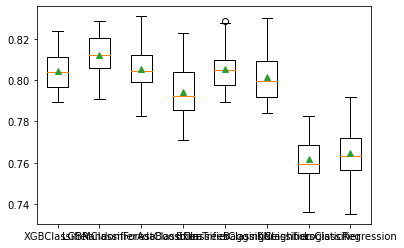

In [24]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [25]:
from sklearn.ensemble import StackingClassifier

In [32]:
# define the base models
level0 = [(name, model) for name, model in en_models.items()]
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_lvl = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

In [34]:
model_lvl.fit(X1, Y1)

StackingClassifier(cv=5,
                   estimators=[('XGBClassifier',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constra...
                                                       n_estimators=1220,

In [28]:
X1_t, df_id = get_test_data_transform_rev1()

In [35]:
Y1_t = model_lvl.predict(X1_t)

In [36]:
pred_df = pd.DataFrame(data=Y1_t, columns=['Transported'])
pred_df['Transported'] = pred_df['Transported'].astype(bool)
df_test = pd.concat([df_id, pred_df], axis=1)
df_test.to_csv('..\\Spaceship Titanic\\ensemble_stack_rev2.csv', index=False)